In [ ]:
%pylab inline

In [2]:
import pyhf
from pyhf import hfpdf

def prep_data(source):
    spec = {
        'singlechannel': {
            'signal': {
                'data': source['bindata']['sig'],
                'mods': [
                    {
                        'name': 'mu',
                        'type': 'normfactor',
                        'data': None
                    }
                ]
            },
            'background': {
                'data': source['bindata']['bkg'],
                'mods': [
                    {
                        'name': 'bkg_norm',
                        'type': 'histosys',
                        'data': {
                            'lo_hist': source['bindata']['bkgsys_dn'],
                            'hi_hist': source['bindata']['bkgsys_up'],
                        }
                    }
                ]
            }
        }
    }
    pdf  = hfpdf(spec)
    data = source['bindata']['data'] + pdf.config.auxdata
    return data, pdf

In [3]:
source = {
  "binning": [2,-0.5,1.5],
  "bindata": {
    "data":    [120.0, 180.0],
    "bkg":     [100.0, 150.0],
    "bkgsys_up":  [102, 190],
    "bkgsys_dn":  [98, 100],
    "sig":     [30.0, 95.0]
  }
}

d,pdf = prep_data(source)
init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

print (d)
print(par_bounds)
print(pdf.config.par_order)


pyhf.tensorlib = pyhf.numpy_backend(poisson_from_normal = True)
print pdf.logpdf(init_pars,d).shape
print pdf.expected_data(init_pars)


pyhf.tensorlib = pyhf.pytorch_backend()
print pdf.logpdf(init_pars,d).shape
print pdf.expected_data(init_pars)

[120.0, 180.0, 0]
[[0, 10], [-5, 5]]
['mu', 'bkg_norm']
(1,)
[132. 285.   1.]
torch.Size([1])
Variable containing:
 132
 285
   1
[torch.FloatTensor of size 3]



In [4]:
pyhf.tensorlib = pyhf.numpy_backend(poisson_from_normal = True)
init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

print pyhf.tensorlib.tolist(pyhf.optimizer.unconstrained_bestfit(pyhf.loglambdav,d,pdf, init_pars, par_bounds))
print pyhf.tensorlib.tolist(pyhf.optimizer.constrained_bestfit(pyhf.loglambdav,1.0,d,pdf, init_pars, par_bounds))
print pyhf.tensorlib.tolist(pyhf.optimizer.constrained_bestfit(pyhf.loglambdav,2.0,d,pdf, init_pars, par_bounds))

[0.5592973068100453, -0.43630942930272826]
[1.0, -1.228110530648936]
[2.0, -3.0072556952837175]


/Users/lukas/Code/histfactory/pyhf/pyhf/tensor/numpy_backend.py:45: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(tensor_in)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1653: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1654: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)


In [6]:
pyhf.tensorlib = pyhf.pytorch_backend()
pyhf.optimizer = pyhf.pytorch_optimizer(tensorlib = pyhf.tensorlib)
init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

print pyhf.tensorlib.tolist(pyhf.optimizer.unconstrained_bestfit(pyhf.loglambdav,d,pdf, init_pars, par_bounds))
print pyhf.tensorlib.tolist(pyhf.optimizer.constrained_bestfit(pyhf.loglambdav,1.0,d,pdf, init_pars, par_bounds))
print pyhf.tensorlib.tolist(pyhf.optimizer.constrained_bestfit(pyhf.loglambdav,2.0,d,pdf, init_pars, par_bounds))

[0.5592615604400635, -0.43627116084098816]
[1.0, -1.2281118631362915]
[2.0, -3.007263422012329]


In [17]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def CLsOnePoint(muTest,d,pdf, init_pars,par_bounds):
    clsobs, cls_exp = pyhf.runOnePoint(muTest, d,pdf,init_pars,par_bounds)[-2:]
    return 1./clsobs, [1./x for x in cls_exp]

def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross

{'exp': [0.3046879979138327,
  0.4278663592309069,
  0.6081810860765774,
  0.8776256008370927,
  1.2094187575023085],
 'obs': 1.1150826072228623}

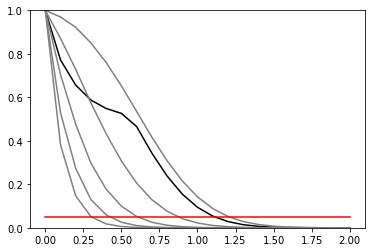

In [18]:
pyhf.tensorlib = pyhf.numpy_backend(poisson_from_normal = True)
init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

mutests = np.linspace(0,2,21)
tests = [CLsOnePoint(muTest,d,pdf,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]
plot_results(mutests, cls_obs, cls_exp)
invert_interval(mutests, cls_obs, cls_exp)

{'exp': [0.304244679363578,
  0.42759359298489874,
  0.6079698391020955,
  0.8775174928004552,
  1.2093040150296162],
 'obs': 1.1150773237840275}

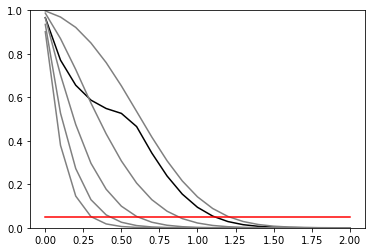

In [19]:
pyhf.tensorlib = pyhf.pytorch_backend()
pyhf.optimizer = pyhf.pytorch_optimizer(tensorlib = pyhf.tensorlib)

mutests = np.linspace(0,2,21)
tests = [CLsOnePoint(muTest,d,pdf,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]
plot_results(mutests, cls_obs, cls_exp)
invert_interval(mutests, cls_obs, cls_exp)